In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

2676


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [15]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    print(dapi_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[0::4], microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    
    break

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.734s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 6.797s.
-- corrected illumination for channel 405 in 7.188s.
- Finished illumination correction in 14.281s.
- apply microscope corrections
- run Cellpose segmentation in 53.719s.
(13, 2048, 2048) 0
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_0.npy


In [11]:
# resize segmentation label back
labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                interpolation=cv2.INTER_NEAREST_EXACT) 
                     for _ly in labels3d])

## Check result

<IPython.core.display.Javascript object>


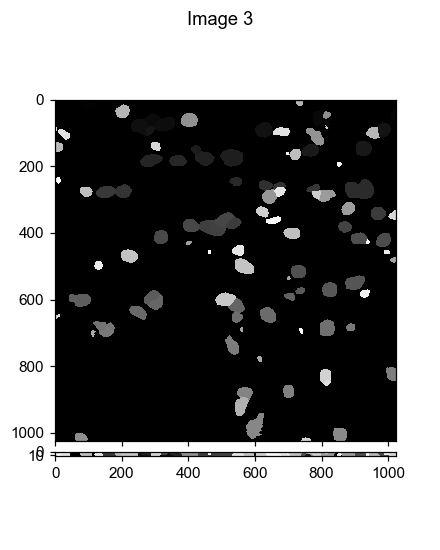

In [16]:
visual_tools.imshow_mark_3d_v2([test_dapi_im, test_polyt_im, labels3d])